In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tensorflow

In [3]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
train_data=pd.read_csv('/content/drive/MyDrive/csvfiles/train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/csvfiles/test.csv')
valid_data=pd.read_csv('/content/drive/MyDrive/csvfiles/valid.csv')

In [5]:
# train_data.head()
# test_data.head(10)
valid_data.head()


,column00,column01,column02,column03,column04,column05,column06,column07,column08,column09,column10,column11,column12,column13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,\N,\N,none,11,43,8,5,105,\N
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [6]:
data=pd.concat([valid_data,train_data,test_data])
data.head()

,column00,column01,column02,column03,column04,column05,column06,column07,column08,column09,column10,column11,column12,column13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,\N,\N,none,11,43,8,5,105,\N
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [7]:
data.column01.unique()

array(['barely-true', 'pants-fire', 'false', 'half-true', 'true',
       'mostly-true'], dtype=object)

In [8]:
attributes = [
    'Id',
    'Label',
    'Statement',
    'Subject',
    'Speaker',
    'Job Title',
    'State',
    'Party',
    'Barely True Counts',
    'False Counts',
    'Half True Counts',
    'Mostly True Counts',
    'Pants on Fire Counts',
    'Context'
]
data.columns=attributes

In [9]:
binary_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}
multiclass_map = {
    'pants-fire': 0,
    'false': 1,
    'barely-true': 2,
    'half-true': 3,
    'mostly-true': 4,
    'true': 5
}

binary_df = data.copy()
multiclass_df = data.copy()

binary_df['label'] = binary_df['Label'].map(binary_map)
multiclass_df['label'] = multiclass_df['Label'].map(multiclass_map)

binary_df.dropna(subset=['label'], inplace=True)
multiclass_df.dropna(subset=['label'], inplace=True)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12836 entries, 0 to 1282
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id                    12836 non-null  object
 1   Label                 12836 non-null  object
 2   Statement             12836 non-null  object
 3   Subject               12836 non-null  object
 4   Speaker               12836 non-null  object
 5   Job Title             12834 non-null  object
 6   State                 12833 non-null  object
 7   Party                 12836 non-null  object
 8   Barely True Counts    12836 non-null  int64 
 9   False Counts          12836 non-null  int64 
 10  Half True Counts      12836 non-null  int64 
 11  Mostly True Counts    12836 non-null  int64 
 12  Pants on Fire Counts  12836 non-null  int64 
 13  Context               12836 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.5+ MB


In [11]:
data.isnull().sum()

,0
Id,0
Label,0
Statement,0
Subject,0
Speaker,0
Job Title,2
State,3
Party,0
Barely True Counts,0
False Counts,0


In [12]:
# Show null counts and their percentages
null_summary = pd.DataFrame({
    'Missing Values': data.isnull().sum(),
    'Percentage (%)': data.isnull().mean() * 100
})
null_summary = null_summary[null_summary['Missing Values'] > 0]
print(null_summary)


           Missing Values  Percentage (%)
Job Title               2        0.015581
State                   3        0.023372


In [13]:
data=data.sample(frac = 1,random_state=42).reset_index(drop=True)
data.head()

,Id,Label,Statement,Subject,Speaker,Job Title,State,Party,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,5235.json,mostly-true,"In the last 22 months, businesses have created...","corrections-and-updates,economy,jobs",barack-obama,President,Illinois,democrat,70,71,160,163,9,the State of the Union address
1,8784.json,false,San Antonio has seen 67% growth in water custo...,"city-budget,city-government,water",robert-puente,"CEO, San Antonio Water System",Texas,democrat,0,1,0,0,0,a Texas Tribune Festival panel discussion
2,6930.json,true,Sherrod Brown failed to pay his own taxes thre...,"message-machine-2012,taxes",josh-mandel,Ohio treasurer,Ohio,republican,4,5,4,5,6,a campaign commercial
3,639.json,pants-fire,Obama wants to increase the size of government...,federal-budget,john-mccain,U.S. senator,Arizona,republican,31,39,31,37,8,"a radio ad called ""Millions"""
4,5708.json,mostly-true,"Lean, finely textured beef is the proper name ...",food-safety,gary-black,Commissioner of Agriculture,Georgia,republican,0,0,1,1,0,a press conference


<ipython-input-14-ae13624bbe5e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=data, palette='Blues_r')


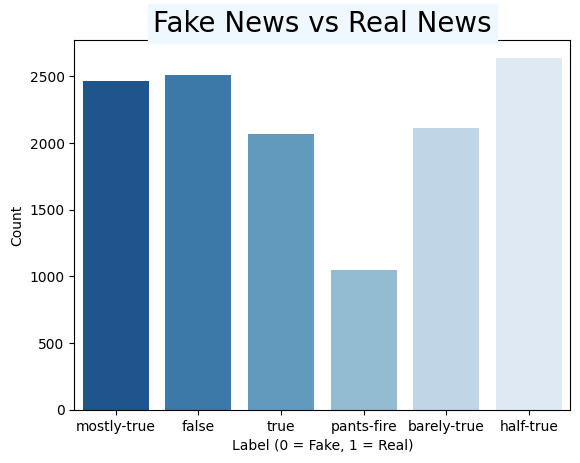

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Label', data=data, palette='Blues_r')
plt.title('Fake News vs Real News', fontsize=20, backgroundcolor='aliceblue')
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.show()


In [15]:
binary_df

,Id,Label,Statement,Subject,Speaker,Job Title,State,Party,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context,label
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,0
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,\N,\N,none,11,43,8,5,105,\N,0
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,0
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,1
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28,23,38,34,7,a news conference,1
1279,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2,0,0,1,0,"on ABC's ""This Week""",0
1280,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1,0,0,0,0,a commentary in The Providence Journal,0
1281,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9,8,10,18,3,a news conference,0


In [16]:
import nltk, spacy, re
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

def preprocess_pipeline(df):
    df['cleaned_text'] = df['Statement'].apply(
        lambda x: ' '.join([w for w in str(x).split() if w.lower() not in stop_words])
    )

    lemma = []
    for doc in nlp.pipe(df['cleaned_text'], batch_size=100, n_process=3):
        lemma.append([t.lemma_ for t in doc if t.lemma_ not in stop_words])
    df['lemma'] = lemma
    df['cleaned_text'] = df['lemma'].apply(lambda x: ' '.join(x))

    def normalize(text):
        text = text.lower()
        text = re.sub(r'(\w)\1+|(.)\2+', r'\1', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s\s+', ' ', text).strip()
        return text

    df['cleaned_text'] = df['cleaned_text'].apply(normalize)
    return df.drop(columns=['lemma'])

data = preprocess_pipeline(data)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
columns_to_drop = [
    'Id',
    'Speaker',
    'Job Title',
    'State',
    'Context',
    'Barely True Counts',
    'False Counts',
    'Half True Counts',
    'Mostly True Counts',
    'Pants on Fire Counts'
]

data = data.drop(columns=columns_to_drop)


In [18]:
binary_df = data.copy()
multiclass_df = data.copy()

binary_df['label'] = binary_df['Label'].map(binary_map)
multiclass_df['label'] = multiclass_df['Label'].map(multiclass_map)

binary_df.dropna(subset=['label'], inplace=True)
multiclass_df.dropna(subset=['label'], inplace=True)

In [19]:
binary_df['cleaned_text'] = data['cleaned_text']
multiclass_df['cleaned_text'] = data['cleaned_text']


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 10000
max_len = 300
embed_size=100
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([binary_df['cleaned_text'], multiclass_df['cleaned_text']], axis=0))


In [21]:
print("binary_df columns:", binary_df.columns.tolist())
print("multiclass_df columns:", multiclass_df.columns.tolist())


binary_df columns: ['Label', 'Statement', 'Subject', 'Party', 'cleaned_text', 'label']
multiclass_df columns: ['Label', 'Statement', 'Subject', 'Party', 'cleaned_text', 'label']


In [22]:
binary_sequences = tokenizer.texts_to_sequences(binary_df['cleaned_text'])
x_binary = pad_sequences(binary_sequences, maxlen=max_len, padding='post', truncating='post')
y_binary = binary_df['label'].astype('float32').values  # binary labels: 0.0 or 1.0


In [23]:
multiclass_sequences = tokenizer.texts_to_sequences(multiclass_df['cleaned_text'])
x_multi = pad_sequences(multiclass_sequences, maxlen=max_len, padding='post', truncating='post')
y_multi = multiclass_df['label'].astype('int32').values  # multi-class labels: 0–5


In [24]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(
    x_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

x_train_multi, x_test_multi, y_train_multi, y_test_multi = train_test_split(
    x_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi)

print("Binary Classification →")
print(f"x_train_bin: {x_train_bin.shape}, y_train_bin: {y_train_bin.shape}")
print(f"x_test_bin: {x_test_bin.shape}, y_test_bin: {y_test_bin.shape}")

print("\nMulti-class Classification →")
print(f"x_train_multi: {x_train_multi.shape}, y_train_multi: {y_train_multi.shape}")
print(f"x_test_multi: {x_test_multi.shape}, y_test_multi: {y_test_multi.shape}")


Binary Classification →
x_train_bin: (10268, 300), y_train_bin: (10268,)
x_test_bin: (2568, 300), y_test_bin: (2568,)

Multi-class Classification →
x_train_multi: (10268, 300), y_train_multi: (10268,)
x_test_multi: (2568, 300), y_test_multi: (2568,)


In [25]:
results = {}

In [26]:
def store_dl_model_results(name, model, history, loss_train, acc_train, loss_test, acc_test, x_test, y_test, task='binary'):
    if task == 'binary':
        y_pred = (model.predict(x_test) > 0.5).astype("int32")
        average = 'binary'
    elif task == 'multiclass':
        y_pred = model.predict(x_test).argmax(axis=1)
        average = 'macro'

    results[name] = {
        "Task": task,
        "Train Loss": round(loss_train, 4),
        "Train Accuracy": round(acc_train, 4),
        "Test Loss": round(loss_test, 4),
        "Test Accuracy": round(acc_test, 4),
        "Precision": precision_score(y_test, y_pred, average=average),
        "Recall": recall_score(y_test, y_pred, average=average),
        "F1-Score": f1_score(y_test, y_pred, average=average)
    }


**Uni-LSTM**

Binary

In [27]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report


LSTM_model_uni = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model_uni.summary()


early_stop_uni = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=2,restore_best_weights=True)
LSTM_model_uni.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
history_LSTM_uni = LSTM_model_uni.fit(x_train_bin, y_train_bin,epochs=5,validation_split=0.2,batch_size=30,shuffle=True,callbacks=[early_stop_uni])


loss_train_uni, acc_train_uni = LSTM_model_uni.evaluate(x_train_bin, y_train_bin)
loss_test_uni, acc_test_uni = LSTM_model_uni.evaluate(x_test_bin, y_test_bin)

print("\nResults of Unidirectional LSTM model (Binary):")
print("Train Loss:", loss_train_uni, "  Accuracy:", acc_train_uni)
print("Test Loss:", loss_test_uni, "  Accuracy:", acc_test_uni)

store_dl_model_results(name="Uni-LSTM_bin",model=LSTM_model_uni,history=history_LSTM_uni,loss_train=loss_train_uni,
                       acc_train=acc_train_uni,loss_test=loss_test_uni,acc_test=acc_test_uni,x_test=x_test_bin,y_test=y_test_bin,task='binary')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5533 - loss: 0.6899 - val_accuracy: 0.5648 - val_loss: 0.6862
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5559 - loss: 0.6880 - val_accuracy: 0.5648 - val_loss: 0.6849
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5578 - loss: 0.6872 - val_accuracy: 0.5648 - val_loss: 0.6853
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5515 - loss: 0.6883 - val_accuracy: 0.5648 - val_loss: 0.6850
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5587 - loss: 0.6863
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5752 - loss: 0.6826

Results of Unidirectional LSTM model (Binary):
Train Loss: 0.6863411664962769   Accuracy: 0.5583365559577942
Test Loss: 0.6863259077072144   Accuracy: 0.5584112405776978
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Multiclass

In [28]:
LSTM_model_multi = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

LSTM_model_multi.summary()


LSTM_model_multi.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
early_stop_multi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_LSTM_multi = LSTM_model_multi.fit(x_train_multi, y_train_multi,validation_split=0.2,epochs=5,batch_size=30,shuffle=True,callbacks=[early_stop_multi])


loss_train_multi, acc_train_multi = LSTM_model_multi.evaluate(x_train_multi, y_train_multi)
loss_test_multi, acc_test_multi = LSTM_model_multi.evaluate(x_test_multi, y_test_multi)
print("\nResults of Unidirectional LSTM model (Multi-Class):")
print("Train Loss:", loss_train_multi, "  Accuracy:", acc_train_multi)
print("Test Loss:", loss_test_multi, "  Accuracy:", acc_test_multi)

store_dl_model_results(name="Uni-LSTM_multi",model=LSTM_model_multi,history=history_LSTM_multi,loss_train=loss_train_multi,
                       acc_train=acc_train_multi,loss_test=loss_test_multi,acc_test=acc_test_multi,x_test=x_test_multi,y_test=y_test_multi,task='multiclass')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1840 - loss: 1.7795 - val_accuracy: 0.2030 - val_loss: 1.7565
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1956 - loss: 1.7619 - val_accuracy: 0.2147 - val_loss: 1.7557
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1938 - loss: 1.7619 - val_accuracy: 0.2030 - val_loss: 1.7553
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2002 - loss: 1.7614 - val_accuracy: 0.2147 - val_loss: 1.7538
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1920 - loss: 1.7620 - val_accuracy: 0.2147 - val_loss: 1.7525
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1993 - loss: 1.7557
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2063 - loss: 1.7523

Results of Unidirectional LSTM model (Multi-Class):
Train Loss: 1.7571208477020264   Accuracy: 0.2054927945137024
Test Loss: 1.7571384906768799   Accuracy: 0.20560747385025024
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Bi-LSTM**

Binary

In [29]:
import tensorflow as tf


BiLSTM_model_bin = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')])

BiLSTM_model_bin.summary()


BiLSTM_model_bin.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
early_stop_bilstm = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)


history_bilstm_bin = BiLSTM_model_bin.fit(x_train_bin, y_train_bin,epochs=5,validation_split=0.2,batch_size=30,shuffle=True,callbacks=[early_stop_bilstm])

loss_train_bilstm, acc_train_bilstm = BiLSTM_model_bin.evaluate(x_train_bin, y_train_bin)
loss_test_bilstm, acc_test_bilstm = BiLSTM_model_bin.evaluate(x_test_bin, y_test_bin)


store_dl_model_results(name="Bi-LSTM_bin",model=BiLSTM_model_bin,history=history_bilstm_bin,loss_train=loss_train_bilstm,acc_train=acc_train_bilstm,
                       loss_test=loss_test_bilstm,acc_test=acc_test_bilstm,x_test=x_test_bin,y_test=y_test_bin,task='binary')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.5502 - loss: 0.6899 - val_accuracy: 0.5648 - val_loss: 0.6842
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5605 - loss: 0.6841 - val_accuracy: 0.5789 - val_loss: 0.6639
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6442 - loss: 0.6412 - val_accuracy: 0.6032 - val_loss: 0.6571
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.7110 - loss: 0.5768 - val_accuracy: 0.6134 - val_loss: 0.6890
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.7696 - loss: 0.5004 - val_accuracy: 0.5847 - val_loss: 0.7343
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6907 - loss: 0.5952
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5961 - loss: 0.6569
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


Multiclass

In [30]:
BiLSTM_model_multi = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

BiLSTM_model_multi.summary()


BiLSTM_model_multi.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
early_stop_bilstm_multi = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history_bilstm_multi = BiLSTM_model_multi.fit(x_train_multi, y_train_multi,epochs=5,validation_split=0.2,batch_size=30,shuffle=True,callbacks=[early_stop_bilstm_multi])


loss_train_bilstm_multi, acc_train_bilstm_multi = BiLSTM_model_multi.evaluate(x_train_multi, y_train_multi)
loss_test_bilstm_multi, acc_test_bilstm_multi = BiLSTM_model_multi.evaluate(x_test_multi, y_test_multi)

store_dl_model_results(name="Bi-LSTM_multi",
    model=BiLSTM_model_multi,history=history_bilstm_multi,loss_train=loss_train_bilstm_multi,acc_train=acc_train_bilstm_multi,
                       loss_test=loss_test_bilstm_multi,acc_test=acc_test_bilstm_multi,x_test=x_test_multi,y_test=y_test_multi,task='multiclass')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.1841 - loss: 1.7833 - val_accuracy: 0.2147 - val_loss: 1.7527
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.2080 - loss: 1.7665 - val_accuracy: 0.2147 - val_loss: 1.7534
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.2016 - loss: 1.7606 - val_accuracy: 0.2254 - val_loss: 1.7493
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.2169 - loss: 1.7605 - val_accuracy: 0.2420 - val_loss: 1.7370
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.2535 - loss: 1.7289 - val_accuracy: 0.2478 - val_loss: 1.7332
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2875 - loss: 1.6407
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2336 - loss: 1.7345
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Uni-GRU**

Binary

In [31]:
UniGRU_model_bin = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

UniGRU_model_bin.summary()

UniGRU_model_bin.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)



early_stop_gru = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

history_gru_bin = UniGRU_model_bin.fit(
    x_train_bin, y_train_bin,
    epochs=5,
    validation_split=0.2,
    batch_size=30,
    shuffle=True,
    callbacks=[early_stop_gru]
)

loss_train_gru, acc_train_gru = UniGRU_model_bin.evaluate(x_train_bin, y_train_bin)
loss_test_gru, acc_test_gru = UniGRU_model_bin.evaluate(x_test_bin, y_test_bin)

store_dl_model_results(
    name="Uni-GRU_bin",
    model=UniGRU_model_bin,
    history=history_gru_bin,
    loss_train=loss_train_gru,
    acc_train=acc_train_gru,
    loss_test=loss_test_gru,
    acc_test=acc_test_gru,
    x_test=x_test_bin,
    y_test=y_test_bin,
    task='binary'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5547 - loss: 0.6887 - val_accuracy: 0.5648 - val_loss: 0.6851
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5535 - loss: 0.6888 - val_accuracy: 0.5648 - val_loss: 0.6850
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5583 - loss: 0.6872 - val_accuracy: 0.5648 - val_loss: 0.6855
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5605 - loss: 0.6866 - val_accuracy: 0.5648 - val_loss: 0.6851
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5587 - loss: 0.6863
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5752 - loss: 0.6828
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Multiclass

In [32]:

UniGRU_model_multi = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

UniGRU_model_multi.summary()

UniGRU_model_multi.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)
early_stop_gru_multi = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)
history_gru_multi = UniGRU_model_multi.fit(
    x_train_multi, y_train_multi,
    epochs=5,
    validation_split=0.2,
    batch_size=30,
    shuffle=True,
    callbacks=[early_stop_gru_multi]
)

loss_train_gru_multi, acc_train_gru_multi = UniGRU_model_multi.evaluate(x_train_multi, y_train_multi)
loss_test_gru_multi, acc_test_gru_multi = UniGRU_model_multi.evaluate(x_test_multi, y_test_multi)

store_dl_model_results(
    name="Uni-GRU_multi",
    model=UniGRU_model_multi,
    history=history_gru_multi,
    loss_train=loss_train_gru_multi,
    acc_train=acc_train_gru_multi,
    loss_test=loss_test_gru_multi,
    acc_test=acc_test_gru_multi,
    x_test=x_test_multi,
    y_test=y_test_multi,
    task='multiclass'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1897 - loss: 1.7824 - val_accuracy: 0.2147 - val_loss: 1.7619
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.1824 - loss: 1.7697 - val_accuracy: 0.2147 - val_loss: 1.7590
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.1821 - loss: 1.7695 - val_accuracy: 0.2147 - val_loss: 1.7543
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2022 - loss: 1.7621 - val_accuracy: 0.2147 - val_loss: 1.7562
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.2029 - loss: 1.7669 - val_accuracy: 0.2147 - val_loss: 1.7535
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1993 - loss: 1.7561
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2063 - loss: 1.7530
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Bi-GRU**

Binary

In [33]:

BiGRU_model_bin = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

BiGRU_model_bin.summary()
BiGRU_model_bin.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

early_stop_bigru = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)
history_bigru_bin = BiGRU_model_bin.fit(
    x_train_bin, y_train_bin,
    epochs=5,
    validation_split=0.2,
    batch_size=30,
    shuffle=True,
    callbacks=[early_stop_bigru]
)
loss_train_bigru, acc_train_bigru = BiGRU_model_bin.evaluate(x_train_bin, y_train_bin)
loss_test_bigru, acc_test_bigru = BiGRU_model_bin.evaluate(x_test_bin, y_test_bin)

store_dl_model_results(
    name="BiGRU_bin",
    model=BiGRU_model_bin,
    history=history_bigru_bin,
    loss_train=loss_train_bigru,
    acc_train=acc_train_bigru,
    loss_test=loss_test_bigru,
    acc_test=acc_test_bigru,
    x_test=x_test_bin,
    y_test=y_test_bin,
    task='binary'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.5560 - loss: 0.6889 - val_accuracy: 0.5648 - val_loss: 0.6845
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5568 - loss: 0.6838 - val_accuracy: 0.5759 - val_loss: 0.6728
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.6315 - loss: 0.6481 - val_accuracy: 0.6246 - val_loss: 0.6514
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.7197 - loss: 0.5666 - val_accuracy: 0.6032 - val_loss: 0.6922
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7886 - loss: 0.4852 - val_accuracy: 0.5910 - val_loss: 0.7356
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7191 - loss: 0.5783
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6112 - loss: 0.6503
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


Multiclass

In [34]:
BiGRU_model_multi = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

BiGRU_model_multi.summary()
BiGRU_model_multi.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

early_stop_bigru_multi = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

history_bigru_multi = BiGRU_model_multi.fit(
    x_train_multi, y_train_multi,
    epochs=5,
    validation_split=0.2,
    batch_size=30,
    shuffle=True,
    callbacks=[early_stop_bigru_multi]
)
loss_train_bigru_multi, acc_train_bigru_multi = BiGRU_model_multi.evaluate(x_train_multi, y_train_multi)
loss_test_bigru_multi, acc_test_bigru_multi = BiGRU_model_multi.evaluate(x_test_multi, y_test_multi)
store_dl_model_results(
    name="BiGRU_multi",
    model=BiGRU_model_multi,
    history=history_bigru_multi,
    loss_train=loss_train_bigru_multi,
    acc_train=acc_train_bigru_multi,
    loss_test=loss_test_bigru_multi,
    acc_test=acc_test_bigru_multi,
    x_test=x_test_multi,
    y_test=y_test_multi,
    task='multiclass'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.2030 - loss: 1.7810 - val_accuracy: 0.2147 - val_loss: 1.7570
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.1962 - loss: 1.7646 - val_accuracy: 0.2147 - val_loss: 1.7542
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.2030 - loss: 1.7596 - val_accuracy: 0.2230 - val_loss: 1.7453
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.2326 - loss: 1.7395 - val_accuracy: 0.2537 - val_loss: 1.7254
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2578 - loss: 1.6769 - val_accuracy: 0.2429 - val_loss: 1.7282
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3172 - loss: 1.6753
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2555 - loss: 1.7231
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**CNN**

Binary

In [35]:
CNN_model_bin = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

CNN_model_bin.summary()
CNN_model_bin.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)
early_stop_cnn = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)
history_cnn_bin = CNN_model_bin.fit(
    x_train_bin, y_train_bin,
    epochs=5,
    validation_split=0.2,
    batch_size=30,
    shuffle=True,
    callbacks=[early_stop_cnn]
)
loss_train_cnn, acc_train_cnn = CNN_model_bin.evaluate(x_train_bin, y_train_bin)
loss_test_cnn, acc_test_cnn = CNN_model_bin.evaluate(x_test_bin, y_test_bin)
store_dl_model_results(
    name="CNN_bin",
    model=CNN_model_bin,
    history=history_cnn_bin,
    loss_train=loss_train_cnn,
    acc_train=acc_train_cnn,
    loss_test=loss_test_cnn,
    acc_test=acc_test_cnn,
    x_test=x_test_bin,
    y_test=y_test_bin,
    task='binary'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5110 - loss: 0.6922 - val_accuracy: 0.5648 - val_loss: 0.6840
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5507 - loss: 0.6841 - val_accuracy: 0.5648 - val_loss: 0.6814
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5613 - loss: 0.6740 - val_accuracy: 0.5716 - val_loss: 0.6770
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6234 - loss: 0.6528 - val_accuracy: 0.6018 - val_loss: 0.6653
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7230 - loss: 0.6161 - val_accuracy: 0.6178 - val_loss: 0.6517
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7840 - loss: 0.5524
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6269 - loss: 0.6504
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Multiclass

In [36]:

CNN_model_multi = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_size, input_length=max_len),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

CNN_model_multi.summary()
CNN_model_multi.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
early_stop_cnn_multi = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history_cnn_multi = CNN_model_multi.fit(x_train_multi, y_train_multi, epochs=5,validation_split=0.2,
    batch_size=30,shuffle=True,callbacks=[early_stop_cnn_multi])

loss_train_cnn_multi, acc_train_cnn_multi = CNN_model_multi.evaluate(x_train_multi, y_train_multi)
loss_test_cnn_multi, acc_test_cnn_multi = CNN_model_multi.evaluate(x_test_multi, y_test_multi)

store_dl_model_results(name="CNN_multi",model=CNN_model_multi,history=history_cnn_multi,loss_train=loss_train_cnn_multi,acc_train=acc_train_cnn_multi,
                       loss_test=loss_test_cnn_multi,acc_test=acc_test_cnn_multi,x_test=x_test_multi,y_test=y_test_multi,task='multiclass')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1832 - loss: 1.7837 - val_accuracy: 0.2132 - val_loss: 1.7579
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2051 - loss: 1.7624 - val_accuracy: 0.2196 - val_loss: 1.7514
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2279 - loss: 1.7479 - val_accuracy: 0.2201 - val_loss: 1.7514
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2507 - loss: 1.7357 - val_accuracy: 0.2317 - val_loss: 1.7483
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2829 - loss: 1.7215 - val_accuracy: 0.2361 - val_loss: 1.7449
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4052 - loss: 1.6955
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2400 - loss: 1.7448
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
import pandas as pd
from IPython.display import display

results_df = pd.DataFrame(results).T
binary_df1 = results_df[results_df["Task"] == "binary"].drop(columns="Task")
multiclass_df1 = results_df[results_df["Task"] == "multiclass"].drop(columns="Task")
pd.set_option('display.precision', 4)

print("Binary Classification Models:")
display(binary_df1.style.set_table_attributes("style='display:inline'").set_caption("Binary Classification Results"))

print("\nMulti-Class Classification Models:")
display(multiclass_df1.style.set_table_attributes("style='display:inline'").set_caption("Multi-Class Classification Results"))


Binary Classification Models:


,Train Loss,Train Accuracy,Test Loss,Test Accuracy,Precision,Recall,F1-Score
Uni-LSTM_bin,0.686300,0.558300,0.686300,0.558400,0.558411,1.000000,0.716642
Bi-LSTM_bin,0.604900,0.680200,0.662000,0.592700,0.654459,0.573222,0.611152
Uni-GRU_bin,0.686400,0.558300,0.686400,0.558400,0.558411,1.000000,0.716642
BiGRU_bin,0.591300,0.703100,0.659000,0.603600,0.618451,0.757322,0.680878
CNN_bin,0.571600,0.753000,0.657800,0.611400,0.612720,0.826360,0.703682



Multi-Class Classification Models:


,Train Loss,Train Accuracy,Test Loss,Test Accuracy,Precision,Recall,F1-Score
Uni-LSTM_multi,1.757100,0.205500,1.757100,0.205600,0.034268,0.166667,0.056848
Bi-LSTM_multi,1.658500,0.284700,1.730200,0.231300,0.124841,0.195342,0.133464
Uni-GRU_multi,1.757600,0.205500,1.757600,0.205600,0.034268,0.166667,0.056848
BiGRU_multi,1.685800,0.306900,1.722300,0.250400,0.166755,0.216174,0.181474
CNN_multi,1.705600,0.379300,1.749100,0.239500,0.122566,0.200626,0.149166


**ML Models**

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

ml_data = binary_df.copy()
x_train_ml, x_test_ml, y_train_ml, y_test_ml = train_test_split(
    ml_data['cleaned_text'], ml_data['label'], test_size=0.25, shuffle=True, random_state=42
)
x_train_ml = pd.Series(x_train_ml)
x_test_ml = pd.Series(x_test_ml)

x_train_ml_list = x_train_ml.apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)).tolist()
x_test_ml_list = x_test_ml.apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)).tolist()
tfidf = TfidfVectorizer(max_features=300)
x_train_tfidf = tfidf.fit_transform(x_train_ml_list)
x_test_tfidf = tfidf.transform(x_test_ml_list)

count = CountVectorizer(max_features=300)
x_train_tf = count.fit_transform(x_train_ml_list)
x_test_tf = count.transform(x_test_ml_list)
models = {
    "SVM (C=1)": SVC(C=1),
    "Logistic Regression (C=1)": LogisticRegression(C=1, max_iter=1000),
    "Decision Tree (max_depth=5)": DecisionTreeClassifier(max_depth=5),
    "KNN (k=9)": KNeighborsClassifier(n_neighbors=9),
    "Random Forest 1 (n=400, depth=40)": RandomForestClassifier(n_estimators=400, max_depth=40),
}
rf2 = RandomForestClassifier(n_estimators=300, max_depth=40)

results_ml = {}
def evaluate_model(name, y_true, y_pred):
    results_ml[name] = {
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred), 4),
        "Recall": round(recall_score(y_true, y_pred), 4),
        "F1-Score": round(f1_score(y_true, y_pred), 4)
    }

for name, model in models.items():
    model.fit(x_train_tfidf, y_train_ml)
    y_pred = model.predict(x_test_tfidf)
    evaluate_model(name, y_test_ml, y_pred)

rf2.fit(x_train_tf, y_train_ml)
y_pred_rf2 = rf2.predict(x_test_tf)
evaluate_model("Random Forest 2 (n=300, depth=40)", y_test_ml, y_pred_rf2)
results_df_ml = pd.DataFrame(results_ml).T
print("Machine Learning Model Results (Binary Classification on LIAR Dataset):")
display(results_df_ml)


Machine Learning Model Results (Binary Classification on LIAR Dataset):


,Accuracy,Precision,Recall,F1-Score
SVM (C=1),0.6248,0.6396,0.7596,0.6944
Logistic Regression (C=1),0.6217,0.6416,0.7385,0.6866
Decision Tree (max_depth=5),0.5921,0.5975,0.8368,0.6972
KNN (k=9),0.5575,0.6094,0.5891,0.5991
"Random Forest 1 (n=400, depth=40)",0.6217,0.6244,0.8179,0.7082
"Random Forest 2 (n=300, depth=40)",0.6248,0.6307,0.7996,0.7052


In [39]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
ml_data_multi = multiclass_df.copy()

x_train_ml, x_test_ml, y_train_ml, y_test_ml = train_test_split(
    ml_data_multi['cleaned_text'], ml_data_multi['label'], test_size=0.25, shuffle=True, random_state=42
)
x_train_ml_list = pd.Series(x_train_ml).apply(str).tolist()
x_test_ml_list = pd.Series(x_test_ml).apply(str).tolist()

tfidf = TfidfVectorizer(max_features=300)
x_train_tfidf = tfidf.fit_transform(x_train_ml_list)
x_test_tfidf = tfidf.transform(x_test_ml_list)

count = CountVectorizer(max_features=300)
x_train_tf = count.fit_transform(x_train_ml_list)
x_test_tf = count.transform(x_test_ml_list)

models_multi = {
    "SVM (C=1)": SVC(C=1),
    "Logistic Regression (C=1)": LogisticRegression(C=1, max_iter=1000),
    "Decision Tree (max_depth=5)": DecisionTreeClassifier(max_depth=5),
    "KNN (k=9)": KNeighborsClassifier(n_neighbors=9),
    "Random Forest 1 (n=400, depth=40)": RandomForestClassifier(n_estimators=400, max_depth=40),
}
rf2_multi = RandomForestClassifier(n_estimators=300, max_depth=40)
results_ml_multi = {}
def evaluate_model_multi(name, y_true, y_pred):
    results_ml_multi[name] = {
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision (macro)": round(precision_score(y_true, y_pred, average='macro'), 4),
        "Recall (macro)": round(recall_score(y_true, y_pred, average='macro'), 4),
        "F1-Score (macro)": round(f1_score(y_true, y_pred, average='macro'), 4)
    }

for name, model in models_multi.items():
    model.fit(x_train_tfidf, y_train_ml)
    y_pred = model.predict(x_test_tfidf)
    evaluate_model_multi(name, y_test_ml, y_pred)

rf2_multi.fit(x_train_tf, y_train_ml)
y_pred_rf2 = rf2_multi.predict(x_test_tf)
evaluate_model_multi("Random Forest 2 (n=300, depth=40)", y_test_ml, y_pred_rf2)

results_df_ml_multi = pd.DataFrame(results_ml_multi).T
print("Machine Learning Model Results (Multi-Class Classification on LIAR Dataset):")
display(results_df_ml_multi)


Machine Learning Model Results (Multi-Class Classification on LIAR Dataset):


,Accuracy,Precision (macro),Recall (macro),F1-Score (macro)
SVM (C=1),0.2527,0.2671,0.2235,0.2155
Logistic Regression (C=1),0.2568,0.2537,0.2331,0.2314
Decision Tree (max_depth=5),0.2231,0.3022,0.1842,0.1244
KNN (k=9),0.2175,0.2192,0.2080,0.1988
"Random Forest 1 (n=400, depth=40)",0.2586,0.2571,0.2260,0.2147
"Random Forest 2 (n=300, depth=40)",0.2646,0.2890,0.2336,0.2204


In [68]:
from tabulate import tabulate
import pandas as pd

dl_binary_table = []
dl_multiclass_table = []

for name, vals in results.items():
    row = {
        "Model": name,
        "Accuracy": vals.get("Test Accuracy", None),
        "Precision": vals.get("Precision", None),
        "Recall": vals.get("Recall", None),
        "F1-Score": vals.get("F1-Score", None)
    }
    if vals.get("Task") == "binary":
        dl_binary_table.append(row)
    elif vals.get("Task") == "multiclass":
        dl_multiclass_table.append(row)

ml_binary_table = []
ml_multiclass_table = []

for name, vals in results_ml.items():
    ml_binary_table.append({
        "Model": name,
        "Accuracy": vals.get("Accuracy", None),
        "Precision": vals.get("Precision", None),
        "Recall": vals.get("Recall", None),
        "F1-Score": vals.get("F1-Score", None)
    })

for name, vals in results_ml_multi.items():
    ml_multiclass_table.append({
        "Model": name,
        "Accuracy": vals.get("Accuracy", None),
        "Precision": vals.get("Precision (macro)", None),
        "Recall": vals.get("Recall (macro)", None),
        "F1-Score": vals.get("F1-Score (macro)", None)
    })


final_binary_table = pd.DataFrame(dl_binary_table + ml_binary_table).set_index("Model")
final_multiclass_table = pd.DataFrame(dl_multiclass_table + ml_multiclass_table).set_index("Model")


print("\nBinary Classification Model Comparison:\n")
print(tabulate(final_binary_table, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))

print("\nMulti-Class Classification Model Comparison:\n")
print(tabulate(final_multiclass_table, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))



Binary Classification Model Comparison:

╒═══════════════════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model                             │   Accuracy │   Precision │   Recall │   F1-Score │
╞═══════════════════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Uni-LSTM_bin                      │     0.5584 │      0.5584 │   1.0000 │     0.7166 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Bi-LSTM_bin                       │     0.5927 │      0.6545 │   0.5732 │     0.6112 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Uni-GRU_bin                       │     0.5584 │      0.5584 │   1.0000 │     0.7166 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ BiGRU_bin                         │     0.6036 │      0.6185 │   0.7573 │     0.6809 │
├───────────────────────────────────┼────────────┼─────────────┼────

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def run_stacked_ensemble(models_ml, rf2, dl_models, x_test_tfidf, x_test_tf,
                         x_test_dl, y_test_dl, task='binary'):

    # Split test data for meta training and evaluation (to prevent overfitting)
    meta_x, holdout_x, meta_y, holdout_y = train_test_split(
        list(range(len(y_test_dl))), y_test_dl, test_size=0.5, random_state=42, stratify=y_test_dl
    )

    meta_input_list = []
    holdout_input_list = []

    # ML predictions
    for name, model in models_ml.items():
        preds_all = model.predict(x_test_tfidf)
        meta_input_list.append(preds_all[meta_x].reshape(-1, 1))
        holdout_input_list.append(preds_all[holdout_x].reshape(-1, 1))

    # RF2
    rf_preds_all = rf2.predict(x_test_tf)
    meta_input_list.append(rf_preds_all[meta_x].reshape(-1, 1))
    holdout_input_list.append(rf_preds_all[holdout_x].reshape(-1, 1))

    # DL predictions
    for name, model in dl_models.items():
        raw_pred_all = model.predict(x_test_dl, verbose=0)
        if task == 'binary':
            pred_all = (raw_pred_all > 0.5).astype(int).reshape(-1, 1)
        else:
            pred_all = raw_pred_all.argmax(axis=1).reshape(-1, 1)
        meta_input_list.append(pred_all[meta_x])
        holdout_input_list.append(pred_all[holdout_x])

    # Stack inputs
    X_meta = np.hstack(meta_input_list)
    X_holdout = np.hstack(holdout_input_list)
    y_meta = np.array(y_test_dl)[meta_x]
    y_holdout = np.array(y_test_dl)[holdout_x]

    # Meta model
    meta_clf = RandomForestClassifier(n_estimators=300, max_depth=40, random_state=42)
    meta_clf.fit(X_meta, y_meta)
    y_pred = meta_clf.predict(X_holdout)

    avg = 'binary' if task == 'binary' else 'macro'
    print(f"\nRealistic Final Stacked Model Evaluation ({task}):")
    print(classification_report(y_holdout, y_pred))

    return {
        "Task": task,
        "Accuracy": round(accuracy_score(y_holdout, y_pred), 4),
        "Precision": round(precision_score(y_holdout, y_pred, average=avg), 4),
        "Recall": round(recall_score(y_holdout, y_pred, average=avg), 4),
        "F1-Score": round(f1_score(y_holdout, y_pred, average=avg), 4)
    }


In [70]:
ml_data_bin = binary_df.copy()

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(
    ml_data_bin['cleaned_text'], ml_data_bin['label'], test_size=0.25, shuffle=True, random_state=42
)

x_train_list = x_train_bin.apply(str).tolist()
x_test_list = x_test_bin.apply(str).tolist()

tfidf = TfidfVectorizer(max_features=300)
x_train_tfidf = tfidf.fit_transform(x_train_list)
x_test_tfidf = tfidf.transform(x_test_list)

count = CountVectorizer(max_features=300)
x_train_tf = count.fit_transform(x_train_list)
x_test_tf = count.transform(x_test_list)

x_train_dl = tokenizer.texts_to_sequences(x_train_list)
x_test_dl = tokenizer.texts_to_sequences(x_test_list)

x_train_dl = pad_sequences(x_train_dl, maxlen=max_len, padding='post')
x_test_dl = pad_sequences(x_test_dl, maxlen=max_len, padding='post')


In [71]:
stacked_binary_results = run_stacked_ensemble(
    models_ml=models,
    rf2=rf2,
    dl_models={
        "Bi-LSTM": BiLSTM_model_bin,
        "Uni-LSTM": LSTM_model_uni,
        "Bi-GRU": BiGRU_model_bin,
        "Uni-GRU": UniGRU_model_bin,
        "CNN": CNN_model_bin
    },
    x_test_tfidf=x_test_tfidf,
    x_test_tf=x_test_tf,
    x_test_dl=x_test_dl,
    y_test_dl=y_test_bin,
    task='binary'
)



Realistic Final Stacked Model Evaluation (binary):
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       704
           1       0.71      0.82      0.76       901

    accuracy                           0.71      1605
   macro avg       0.71      0.69      0.70      1605
weighted avg       0.71      0.71      0.70      1605



In [72]:
ml_data_multi = multiclass_df.copy()

x_train_multi, x_test_multi, y_train_multi, y_test_multi = train_test_split(
    ml_data_multi['cleaned_text'], ml_data_multi['label'], test_size=0.25, shuffle=True, random_state=42
)

x_train_list = x_train_multi.apply(str).tolist()
x_test_list = x_test_multi.apply(str).tolist()

tfidf = TfidfVectorizer(max_features=300)
x_train_tfidf_multi = tfidf.fit_transform(x_train_list)
x_test_tfidf_multi = tfidf.transform(x_test_list)

count = CountVectorizer(max_features=300)
x_train_tf_multi = count.fit_transform(x_train_list)
x_test_tf_multi = count.transform(x_test_list)

# 🟢 DL input (tokenized + padded)
x_train_dl_multi = tokenizer.texts_to_sequences(x_train_list)
x_test_dl_multi = tokenizer.texts_to_sequences(x_test_list)

x_train_dl_multi = pad_sequences(x_train_dl_multi, maxlen=max_len, padding='post')
x_test_dl_multi = pad_sequences(x_test_dl_multi, maxlen=max_len, padding='post')

In [62]:
stacked_multiclass_results = run_stacked_ensemble(
    models_ml=models_multi,
    rf2=rf2_multi,
    dl_models={
        "Bi-LSTM": BiLSTM_model_multi,
        "Uni-LSTM": LSTM_model_multi,
        "Bi-GRU": BiGRU_model_multi,
        "Uni-GRU": UniGRU_model_multi,
        "CNN": CNN_model_multi
    },
    x_test_tfidf=x_test_tfidf_multi,
    x_test_tf=x_test_tf_multi,
    x_test_dl=x_test_dl_multi,
    y_test_dl=y_test_multi,
    task='multiclass'
)

print("\n📊 Final Stacked Model Results (Multiclass):")
for k, v in stacked_multiclass_results.items():
    print(f"{k}: {v}")



Realistic Final Stacked Model Evaluation (multiclass):
              precision    recall  f1-score   support

           0       0.25      0.22      0.23       128
           1       0.33      0.37      0.35       315
           2       0.22      0.21      0.21       262
           3       0.36      0.39      0.37       335
           4       0.34      0.35      0.34       314
           5       0.24      0.19      0.21       251

    accuracy                           0.30      1605
   macro avg       0.29      0.29      0.29      1605
weighted avg       0.30      0.30      0.30      1605


📊 Final Stacked Model Results (Multiclass):
Task: multiclass
Accuracy: 0.3028
Precision: 0.2879
Recall: 0.2872
F1-Score: 0.2868


In [73]:
ml_binary_table.append({
    "Model": "Stacked Ensemble (Binary)",
    "Accuracy": stacked_binary_results["Accuracy"],
    "Precision": stacked_binary_results["Precision"],
    "Recall": stacked_binary_results["Recall"],
    "F1-Score": stacked_binary_results["F1-Score"]
})

ml_multiclass_table.append({
    "Model": "Stacked Ensemble (Multiclass)",
    "Accuracy": stacked_multiclass_results["Accuracy"],
    "Precision": stacked_multiclass_results["Precision"],
    "Recall": stacked_multiclass_results["Recall"],
    "F1-Score": stacked_multiclass_results["F1-Score"]
})

final_binary_table = pd.DataFrame(dl_binary_table + ml_binary_table).set_index("Model")
final_multiclass_table = pd.DataFrame(dl_multiclass_table + ml_multiclass_table).set_index("Model")

In [74]:
print("\nBinary Classification Model Comparison:\n")
print(tabulate(final_binary_table, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


Binary Classification Model Comparison:

╒═══════════════════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model                             │   Accuracy │   Precision │   Recall │   F1-Score │
╞═══════════════════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Uni-LSTM_bin                      │     0.5584 │      0.5584 │   1.0000 │     0.7166 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Bi-LSTM_bin                       │     0.5927 │      0.6545 │   0.5732 │     0.6112 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Uni-GRU_bin                       │     0.5584 │      0.5584 │   1.0000 │     0.7166 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ BiGRU_bin                         │     0.6036 │      0.6185 │   0.7573 │     0.6809 │
├───────────────────────────────────┼────────────┼─────────────┼────

In [75]:
print("\nMulti-Class Classification Model Comparison:\n")
print(tabulate(final_multiclass_table, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


Multi-Class Classification Model Comparison:

╒═══════════════════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model                             │   Accuracy │   Precision │   Recall │   F1-Score │
╞═══════════════════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Uni-LSTM_multi                    │     0.2056 │      0.0343 │   0.1667 │     0.0568 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Bi-LSTM_multi                     │     0.2313 │      0.1248 │   0.1953 │     0.1335 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Uni-GRU_multi                     │     0.2056 │      0.0343 │   0.1667 │     0.0568 │
├───────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ BiGRU_multi                       │     0.2504 │      0.1668 │   0.2162 │     0.1815 │
├───────────────────────────────────┼────────────┼─────────────